# Beta-binomial hierarchical model for batting averages

In Lec20, which introduced the notion of **shrinkage**, we discussed the Efron & Morris (EM) demonstration of shrinkage using data on the batting averages for baseball players.  EM computed their shrinkage estimates using an analytical formula appropriate for data with additive errors whose probability distributions are IID *normal*.  To make this work, they used a nonlinear *variance stabilizing transformation* of the reported averages (ratios of counts); this makes the distribution for the transformed data approximately normal.

Here, we'll treat the data without such an approximation, using a beta-binomial hierarchical model.

In [1]:
from io import StringIO

import pandas as pd  # we'll use Pandas to read and parse the data
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib.pyplot import *
from numpy import *
from scipy import stats

from stanfitter import StanFitter
# Plotting helper:
from shrinkage_plot import shrinkage_plot

In [2]:
# Efron-Morris baseball data in CSV format:
csv_data = StringIO("""
Player,First45,Remainder, JS
Clemente, 0.400, 0.346, 0.290
F.~Robinson, 0.378, 0.298, 0.286
F.~Howard, 0.356, 0.276, 0.282
Johnstone, 0.333, 0.222, 0.277
Berry, 0.311, 0.273, 0.273
Spencer, 0.311, 0.270, 0.273
Kessinger, 0.289, 0.263, 0.268
Alvarado, 0.267, 0.210, 0.264
Santo, 0.244, 0.269, 0.259
Swoboda, 0.244, 0.230, 0.259
Unser, 0.222, 0.264, 0.254
Williams, 0.222, 0.256, 0.254
Scott, 0.222, 0.303, 0.254
Petrocelli, 0.222, 0.264, 0.254
Rodriguez, 0.222, 0.226, 0.254
Campaneris, 0.200, 0.285, 0.249
Munson, 0.178, 0.316, 0.244
Alvis, 0.156, 0.200, 0.239
""")

bbdata = pd.read_csv(csv_data)
bbdata

,Player,First45,Remainder,JS
0,Clemente,0.400,0.346,0.290
1,F.~Robinson,0.378,0.298,0.286
2,F.~Howard,0.356,0.276,0.282
3,Johnstone,0.333,0.222,0.277
4,Berry,0.311,0.273,0.273
5,Spencer,0.311,0.270,0.273
6,Kessinger,0.289,0.263,0.268
7,Alvarado,0.267,0.210,0.264
8,Santo,0.244,0.269,0.259
9,Swoboda,0.244,0.230,0.259


In [3]:
n_players = len(bbdata)

# Number of at-bats for First45:
n_at_bat = 45

# Numbers of hits for First45:
n_hits = round(n_at_bat*bbdata['First45'])
n_hits = array(n_hits, dtype=int)
n_players, n_hits

(18,
 array([18, 17, 16, 15, 14, 14, 13, 12, 11, 11, 10, 10, 10, 10, 10,  9,  8,
         7]))

## Parameterization for the beta population distribution

We'll adopt a beta distribution as the population distribution for the batting averages.

Denoting the batting average (as a fraction) for player $i$ by $\alpha_i$ (it will be `bavgs[i]` in the code), the usual $(a,b)$ parameterization of the beta distribution would give the population distribution as
$$
p(\alpha_i|a,b) = \frac{1}{B(a,b)} \alpha_i^{a-1} (1-\alpha_i)^{b-1},
$$
where $B(a,b)$ denotes the beta integral, serving as a normalization constant.

We'll instead adopt a more interpretable parameterization, using the population distribution mean, $\mu$, and standard deviation, $\sigma$, as parameters.  Recall that these moments are related to $(a,b)$ as follows:
\begin{align}
\mu &= \frac{a}{a+b},\\
\sigma^2 &= \frac{a b}{(a+b)^2 (a+b+1)} = \frac{\mu(1-\mu)}{a+b+1}.
\end{align}
If we specify $(\mu,\sigma)$, we'll need expressions for $a$ and $b$ in terms of these. A bit of algebra yields:
\begin{align}
a &= \mu \left( \frac{\mu(1-\mu)}{\sigma^2} - 1\right),\\
b &= a \frac{1-\mu}{\mu}.
\end{align}
The following code defines functions implementing these transformations, and doing a quick consistency check.

In [4]:
def moments2ab(mu, sig):
    """
    Return the beta dist'n (a,b) params given the mean and std dev'n
    of alpha, `mu` and `sig`.
    """
    a = mu*(mu*(1.-mu)/sig**2 - 1.)
    b = a*(1.-mu)/mu
    return a, b

def ab2moments(a, b):
    """
    Return the mean and std dev'n of alpha for a beta dist'n with
    shape params `a` and `b`.
    """
    return a/(a+b), sqrt(a*b/((a+b)**2 * (a+b+1.)))

def test_trans(a,b):
    print('\na,b:', a, b)
    print('Moments:', ab2moments(a,b))
    print('a,b:', moments2ab(*ab2moments(a,b)))

test_trans(1,1)
test_trans(.5,.5)
test_trans(30,70)


a,b: 1 1
Moments: (0.5, 0.28867513459481287)
a,b: (1.0, 1.0)

a,b: 0.5 0.5
Moments: (0.5, 0.3535533905932738)
a,b: (0.4999999999999998, 0.4999999999999998)

a,b: 30 70
Moments: (0.3, 0.045598332434334476)
a,b: (29.999999999999993, 69.99999999999999)


In [5]:
moments2ab(0.345061, 0.235276)

(1.0637000953637343, 2.0189435397145106)

## Prior for the beta population distribution parameters

We'll adopt a prior for $(\mu,\sigma)$ that aims to be uninformative, i.e., to allow diverse beta distributions a priori.  From the formulas for $\mu$ and $\sigma$, note that they are necessarily related, in that we can write the variance as
$$
\sigma^2 = \frac{\mu(1-\mu)}{a+b+1}.
$$
Since $a$ and $b$ must each be $> 0$, this relationship implies that
$$
\sigma^2 < \mu(1-\mu).
$$
That is, given a value for $\mu$, there is an *upper limit* on the allowed value of $\sigma$. And if $\mu=0$ or $\mu=1$, then necessarily $\sigma=0$.

We'll adopt a flat prior for $\mu$ over nearly its full $[0,1]$ range, making it flat over the interval $[\mu_l=0.05, \mu_u=0.95]$.  We avoid setting $\mu_l = 0$ or $\mu_u=1$, firstly because we don't believe it all likely that *every* player is a perfect hitter ($\mu=1,\sigma=0$) or a perfectly *bad* hitter ($\mu=0,\sigma=0$). Also, when $\mu$ is at or near one 0 or 1, the population distribution becomes nearly divergent; setting bounds away from these troublesome points will avoid potential numerical problems with handling nearly degenerate distributions.

For $\sigma$, let's consider flat priors for $\sigma$ or for $\sigma^2$ up to **near** the $\mu$-dependent upper limit.  We'll set the upper limit to $\sigma$ to be
$$
\sigma_u = \frac{\mu(1-\mu)}{c},
$$
where $c$ is a constant greater than 1, denoted `ab1` in the code since it represents the smallest allowed value of $a+b+1$.

Let's look at what various priors imply for choices of beta distributions.  We'll keep track of how many prior samples have $a>1$ and $b>1$; these are cases that don't peak at a boundary, which are the most reasonable cases.

**Flat in $\mu$ and conditionally flat in $\sigma$; lower limit on $a+b+1$:**

Positive exponent cases: 75 0.75


(0.0, 20.0)

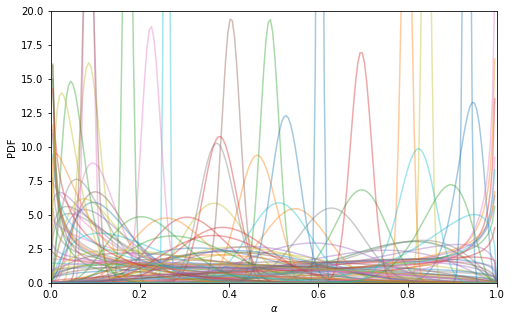

In [6]:
mu_l=0.05
mu_u=0.95
dmu = mu_u - mu_l

figure(figsize=(8,5))
alphas = linspace(0., 1., 200)
npos = 0  # count cases with a, b >= 1
ncases = 100
# ab1 = smallest allowed value of a+b+1
ab1 = 3  # **EXPERIMENT WITH THIS**
for i in range(ncases):
    mu = stats.uniform(mu_l, dmu).rvs()
    sig = stats.uniform(0., sqrt(mu*(1.-mu)/ab1)).rvs()
    a, b = moments2ab(mu, sig)
    # Count cases that peak inside the interval.
    if a >= 1. and b >= 1.:
        npos += 1
    pdf = stats.beta(a,b).pdf(alphas)
    plot(alphas, pdf, '-', alpha=.4)
print('Positive exponent cases:', npos, npos/ncases)
xlabel(r'$\alpha$')
ylabel('PDF')
xlim(0., 1.)
ylim(0., 20.)

**Flat in $\mu$ and conditionally flat in $\sigma^2$:**

Positive exponent cases: 60 0.6


(0.0, 20.0)

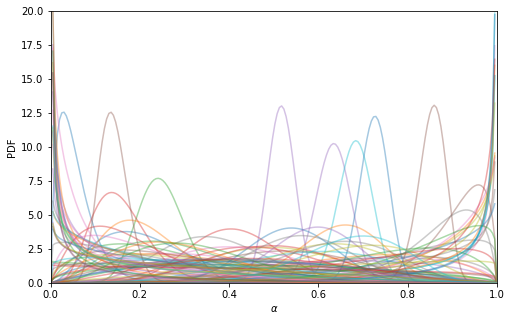

In [7]:
figure(figsize=(8,5))
npos = 0  # count cases with a, b >= 1
# ab1 = smallest allowed value of a+b+1
ab1 = 3.  # **EXPERIMENT WITH THIS**
for i in range(ncases):
    mu = stats.uniform(mu_l, dmu).rvs()
    v = stats.uniform(0., mu*(1.-mu)/ab1).rvs()
    sig = sqrt(v)
    a, b = moments2ab(mu, sig)
    # Count cases that peak inside the interval.
    if a >= 1. and b >= 1.:
        npos += 1
    pdf = stats.beta(a,b).pdf(alphas)
    plot(alphas, pdf, '-', alpha=.4)
print('Positive exponent cases:', npos, npos/ncases)
xlabel(r'$\alpha$')
ylabel('PDF')
xlim(0., 1.)
ylim(0., 20.)

Based on these experiments, I'm choosing to use a conditionally flat prior in $\sigma$, with $c=3$; this seems to allow a bit more diversity in the possible populations, while still keeping most candidates with $a>1, b>1$.

## Stan code for a beta-binomial hierarchical model

Writing working Stan code for this model turned out to be a little tricky.  I originally wrote it with $(a,b)$ in a `transformed parameters` block, like this:
```
transformed parameters {
    real<lower=0> a;  // beta shape param
    real<lower=0> b;  // beta shape param

    a = mu*(mu*(1.-mu)/sig^2 - 1.);
    b = a*(1.-mu)/mu;
}
```
This caused problems, with $a$ or $b$ assigned an illegal value.  The Stan manual doesn't specify the evaluation order for a `transformed parameters` block.  My guess is that the problem is due to the conditional nature of the $\sigma$ prior interacting with transformed parameters.

What ended up working is putting the $(a,b)$ transformation in the `model` block, ensuring that their values are set only *after* good values for $(\mu,\sigma)$ are set.

In [8]:
# Stan code defining a beta-binomial MLM for batting averages:
bb_code = """
data {
    int<lower=0> n_players; 
    int n_at_bat;
    int<lower=0> hits[n_players];

    real<lower=0> mu_l;  // mean batting avg lower limit
    real<lower=0> mu_u;  // mean batting avg upper limit
    real<lower=1> ab1;   // lowest allowed value of beta a+b+1
} 

parameters {
    real<lower=0,upper=1> mu;  // mean batting avg
    real<lower=0> sig; // dispersion in batting avgs
    real<lower=0,upper=1> bavgs[n_players];
}

model {
    real a;  // beta shape param
    real b;  // beta shape param

    mu ~ uniform(mu_l, mu_u);  // flat hyperprior
    sig ~ uniform(0., sqrt(mu*(1.-mu)/ab1));  // flat up to cond'l max
    // print("mu=", mu, " sig=", sig);

    a = mu*(mu*(1.-mu)/sig^2 - 1.);
    b = a*(1.-mu)/mu;
    // print("a=", a, " b=", b);

    for (i in 1:n_players){
        bavgs[i] ~ beta(a, b);
        hits[i] ~ binomial(n_at_bat, bavgs[i]);
    }
}
"""

In [9]:
# Stan code defining a beta-binomial MLM for batting averages:
# (This version imposes a small, nonzero lower limit for sig.)
bb_code2 = """
data {
    int<lower=0> n_players; 
    int n_at_bat;
    int<lower=0> hits[n_players];

    real<lower=0> mu_l;  // mean batting avg lower limit
    real<lower=0> mu_u;  // mean batting avg upper limit
    real<lower=1> ab1;   // lowest allowed value of beta a+b+1
} 

parameters {
    real<lower=0,upper=1> mu;  // mean batting avg
    real<lower=0> sig; // dispersion in batting avgs
    real<lower=0,upper=1> bavgs[n_players];
}

model {
    real a;  // beta shape param
    real b;  // beta shape param

    mu ~ uniform(mu_l, mu_u);  // flat hyperprior
    sig ~ uniform(0.02, sqrt(mu*(1.-mu)/ab1));  // flat up to cond'l max
    // print("mu=", mu, " sig=", sig);

    a = mu*(mu*(1.-mu)/sig^2 - 1.);
    b = a*(1.-mu)/mu;
    // print("a=", a, " b=", b);

    for (i in 1:n_players){
        bavgs[i] ~ beta(a, b);
        hits[i] ~ binomial(n_at_bat, bavgs[i]);
    }
}
"""

In [10]:
# Stan code defining a beta-binomial MLM for batting averages:
# (This version imposes a small, nonzero lower limit for sig.)
bb_code3 = """
data {
    int<lower=0> n_players; 
    int n_at_bat;
    int<lower=0> hits[n_players];

    real<lower=0> mu_l;  // mean batting avg lower limit
    real<lower=0> mu_u;  // mean batting avg upper limit
    real<lower=1> ab1;   // lowest allowed value of beta a+b+1
} 

parameters {
    real<lower=0,upper=1> mu;  // mean batting avg
    real<lower=0> sig; // dispersion in batting avgs
    real<lower=0,upper=1> bavgs[n_players];
}

transformed parameters {
  real<lower=0> a = mu*(mu*(1.-mu)/sig^2 - 1.);
  real<lower=0> b = a*(1.-mu)/mu;
}

model {
    mu ~ uniform(mu_l, mu_u);  // flat hyperprior
    sig ~ uniform(0.02, sqrt(mu*(1.-mu)/ab1));  // flat up to cond'l max
    // print("mu=", mu, " sig=", sig);
    // print("a=", a, " b=", b);

    for (i in 1:n_players){
        bavgs[i] ~ beta(a, b);
        hits[i] ~ binomial(n_at_bat, bavgs[i]);
    }
}
"""

## Stan fits

Finally we can do some fits!

In [11]:
# Invoke Stan to build the model, caching the built model in the CWD to save
# time if the script is re-run without any Stan code changes.
# bb_fitter = StanFitter(bb_code, name='Baseball')
bb_fitter = StanFitter(bb_code3, name='Baseball3')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c534a256e9b93243926161fa90fbce39 NOW.
clang-11: warning: -Wl,-export_dynamic: 'linker' input unused [-Wunused-command-line-argument]
In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_in934dwo/stanfit4anon_model_c534a256e9b93243926161fa90fbce39_8694905601972447528.cpp:777:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969:
/Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_in934dwo/stanfit4anon_model_c534a256e9b93243926161fa90fbce39_8694905601972447528.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_in934dwo/stanfit4anon_model_c534a256e9b93243926161fa90fbce39_8694905601972447528.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_in934dwo/stanfit4anon_model_c534a256e9b93243926161fa90fbce39_8694905601972447528.cpp:787:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::random::linear_

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_in934dwo/stanfit4anon_model_c534a256e9b93243926161fa90fbce39_8694905601972447528.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_in934dwo/stanfit4anon_model_c534a256e9b93243926161fa90fbce39_8694905601972447528.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_in934dwo/stanfit4anon_model_c534a256e9b93243926161fa90fbce39_8694905601972447528.cpp:787:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:82:16: note: in instantiation of member function 'boost::random::linear_cong

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_in934dwo/stanfit4anon_model_c534a256e9b93243926161fa90fbce39_8694905601972447528.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_in934dwo/stanfit4anon_model_c534a256e9b93243926161fa90fbce39_8694905601972447528.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_in934dwo/stanfit4anon_model_c534a256e9b93243926161fa90fbce39_8694905601972447528.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_in934dwo/stanfit4anon_model_c534a256e9b93243926161fa90fbce39_8694905601972447528.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/pystan/stan/lib/s

        ret = command(args, model_, holder, names_oi_tidx_,
              ^
/var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_in934dwo/stanfit4anon_model_c534a256e9b93243926161fa90fbce39_8694905601972447528.cpp:9591:34: note: in instantiation of member function 'pystan::stan_fit<anon_model_c534a256e9b93243926161fa90fbce39_namespace::anon_model_c534a256e9b93243926161fa90fbce39, boost::random::additive_combine_engine<boost::random::linear_congruential_engine<unsigned int, 40014, 0, 2147483563>, boost::random::linear_congruential_engine<unsigned int, 40692, 0, 2147483399>>>::call_sampler' requested here
    __pyx_t_15 = __pyx_v_fitptr->call_sampler((*__pyx_v_argsptr), (*__pyx_v_holderptr));
                                 ^
In file included from /var/folders/qf/ngr7kyqj1yx7qkz145_l0f2h0000gn/T/pystan_in934dwo/stanfit4anon_model_c534a256e9b93243926161fa90fbce39_8694905601972447528.cpp:786:
In file included from /Users/loredo/opt/miniconda3/envs/py37stan2/lib/python3.7/site-packages/

152 warnings generated.
ld: warning: -pie being ignored. It is only used when linking a main executable


In [12]:
bb_data = dict(n_players=n_players, n_at_bat=n_at_bat, hits=n_hits,
               mu_l=mu_l, mu_u=mu_u, ab1=3.)
# bb_data = dict(n_players=n_players, n_at_bat=n_at_bat, hits=n_hits, ab_max=200.)
bb_fitter.set_data(bb_data)

In [13]:
n_iter, n_chains = 10000, 4
bb_fit = bb_fitter.sample(n_iter, n_chains)


>>> Using conservative adapt_delta = 0.95 (vs. Stan default of 0.8). <<<

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: validate transformed params: a is -0.300807, but must be greater than or equal to 0  (in 'unknown file name' at line 19)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: validate transformed params: a is -0.751406, but must be greater than or equal to 0  (in 'unknown file name' at line 19)

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: validate transformed params: a is -0.338665, but must be greater than or equal to 0  (in 'unknown file name' at line 19)

Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: validate transformed params: a

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: a is -0.00360133, but must be greater than or equal to 0  (in 'unknown file name' at line 19)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: a is -0.000261274, but must be greater than or equal to 0  (in 'unknown file name' at line 19)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: Th

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: a is -0.0229146, but must be greater than or equal to 0  (in 'unknown file name' at line 19)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: a is -0.21926, but must be greater than or equal to 0  (in 'unknown file name' at line 19)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The cur

Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: a is -0.229739, but must be greater than or equal to 0  (in 'unknown file name' at line 19)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: a is -0.000492758, but must be greater than or equal to 0  (in 'unknown file name' at line 19)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: validate transformed params: a is -0.180351, but must be greater than or equal to 0  (in 'unknown file name' at line 19)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 1.91501 seconds (Warm-up)
               1.32558 seconds (Sampling)
               3.24059 seconds (Total)

Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 1.92293 seconds (Warm-up)
               2.06784 seconds (Sampling)
               3.99078 seconds (Total)

Iteration: 7000 / 10000

Stan may sometime report problems with "divergence." This refers to evidence that chains are approaching equilibrium too slowly, and indicates you should carefully look at the results (esp. ESS and trace plots) for evidence that some parameters (or their priors) need further consideration. For discussion of this, see: [Diagnosing Biased Inference with Divergences](https://betanalpha.github.io/assets/case_studies/divergences_and_bias.html).

In [14]:
print(bb_fit.mu)
print(bb_fit.sig)

Parameter <mu> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 5415
Mean (se), median, sd:  0.267 (0.000256),  0.267,  0.0188
Central intvls:  50%: [0.255, 0.28];  95%: [0.231, 0.305]

Parameter <sig> summary:
Convergence and mixing diagnostics:  Rhat = 1.00, ESS = 2454
Mean (se), median, sd:  0.0428 (0.000347),  0.0393,  0.0172
Central intvls:  50%: [0.0293, 0.0526];  95%: [0.0209, 0.0835]



In [15]:
print(bb_fit)

PyStan's fit summary:
[*** NOTE: PyStan uses 1-based array indexing here! ***]

Inference for Stan model: anon_model_c534a256e9b93243926161fa90fbce39.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu          0.27  2.6e-4   0.02   0.23   0.25   0.27   0.28   0.31   5416    1.0
sig         0.04  3.5e-4   0.02   0.02   0.03   0.04   0.05   0.08   2455    1.0
bavgs[1]    0.31  5.3e-4   0.04   0.23   0.28    0.3   0.33   0.41   7082    1.0
bavgs[2]     0.3  4.9e-4   0.04   0.23   0.27    0.3   0.32    0.4   7589    1.0
bavgs[3]    0.29  4.2e-4   0.04   0.22   0.26   0.29   0.32   0.38   9433    1.0
bavgs[4]    0.29  4.0e-4   0.04   0.22   0.26   0.28   0.31   0.37   9624    1.0
bavgs[5]    0.28  3.5e-4   0.04   0.21   0.25   0.28    0.3   0.37  12543    1.0
bavgs[6]    0.28  3.4e-4   0.04   0.21   0.25   0.28    0.3   0.37  12712    1.0


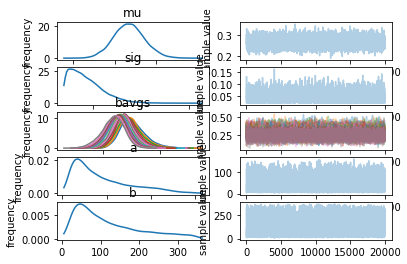

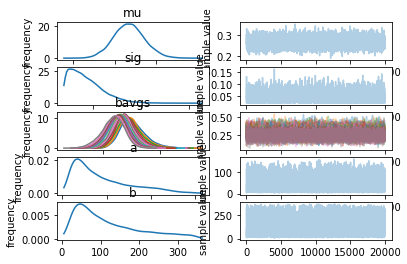

In [16]:
bb_fit.stan_plot()

In [17]:
# Check Rhat and ESS for pop'n params.
scalars = [bb_fit.mu, bb_fit.sig]
print('*** Checks for convergence, mixing ***')
print('Rhat, ESS for scalar params:')
for param in scalars:
    print('    {0:12s}:  {1:6.3f}  {2:6.0f}'.format(param.name, param.Rhat, param.ess))


*** Checks for convergence, mixing ***
Rhat, ESS for scalar params:
    mu          :   1.000    5416
    sig         :   1.001    2455


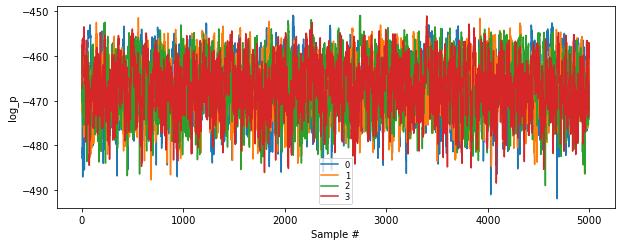

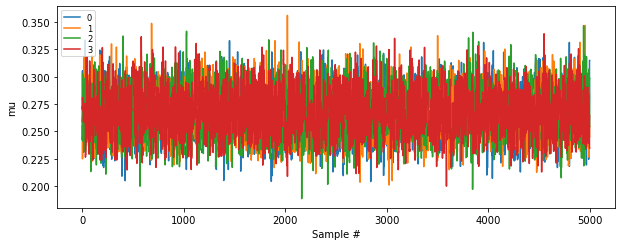

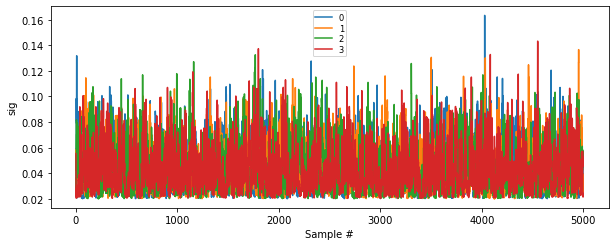

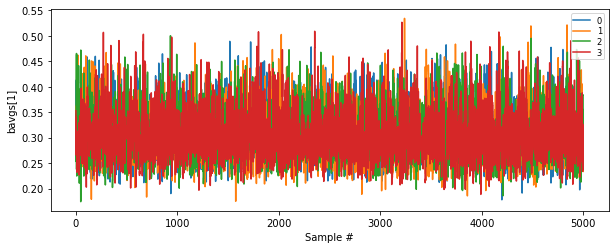

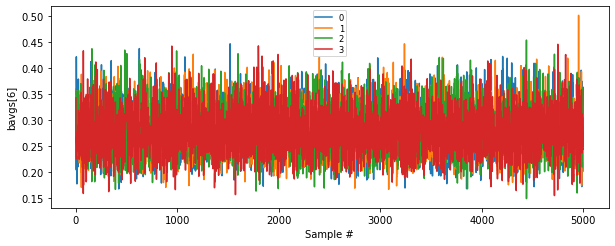

In [18]:
# Some trace plots:
bb_fit.log_p.trace()
bb_fit.mu.trace()
bb_fit.sig.trace()
bb_fit.bavgs[0].trace()
bb_fit.bavgs[5].trace()

In [19]:
# Quick-and-dirty estimate of the posterior mode as the
# sample with the largest log_p.  *Note:*  This is not
# a great estimate in large-dimensional parameter spaces. 
i_max = bb_fit.log_p.thinned.argmax()
mu_hat = bb_fit.mu.thinned[i_max]
sig_hat = bb_fit.sig.thinned[i_max]
print('Rough estimate of ($\mu,\sigma$) mode:', mu_hat, sig_hat)

Rough estimate of ($\mu,\sigma$) mode: 0.2828106838285602 0.020085436803916345


Text(0, 0.5, '$p(\\sigma|D)$')

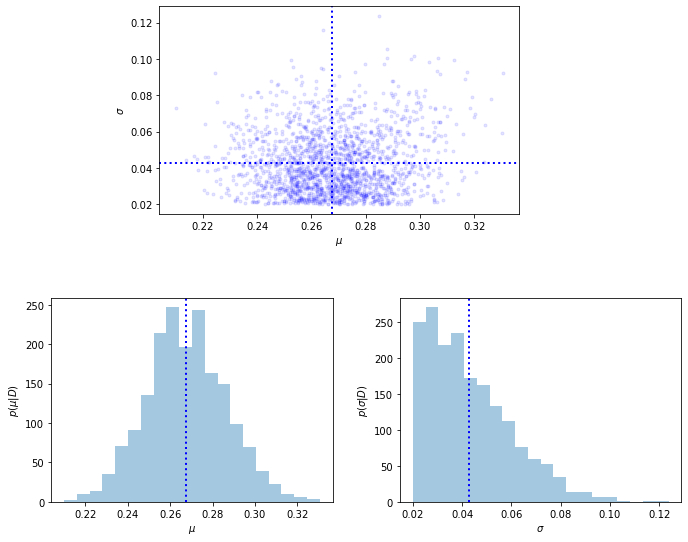

In [20]:
f = figure(figsize=(10,8))
subplots_adjust(bottom=.1, left=.1, right=.975, wspace=.24, )

# subplot(232)  # joint at mid-top
f.add_axes([.25, .6, .5, .36])
plot(bb_fit.mu.thinned, bb_fit.sig.thinned, 'b.', alpha=.1)
# crosshair showing mean values:
xhair = { 'color' : 'b', 'linestyle' : ':' , 'linewidth' : 2}
axvline(bb_fit.mu.mean, **xhair)
axhline(bb_fit.sig.mean, **xhair)
xlabel(r'$\mu$')
ylabel(r'$\sigma$')

subplot(223)  # marginal for mu bottom-left
hist(bb_fit.mu.thinned, 20, alpha=.4)
axvline(bb_fit.mu.mean, **xhair)
xlabel(r'$\mu$')
ylabel(r'$p(\mu|D)$')

subplot(224)  # marginal for sig bottom-right
hist(bb_fit.sig.thinned, 20, alpha=.4)
axvline(bb_fit.sig.mean, **xhair)
xlabel(r'$\sigma$')
ylabel(r'$p(\sigma|D)$')

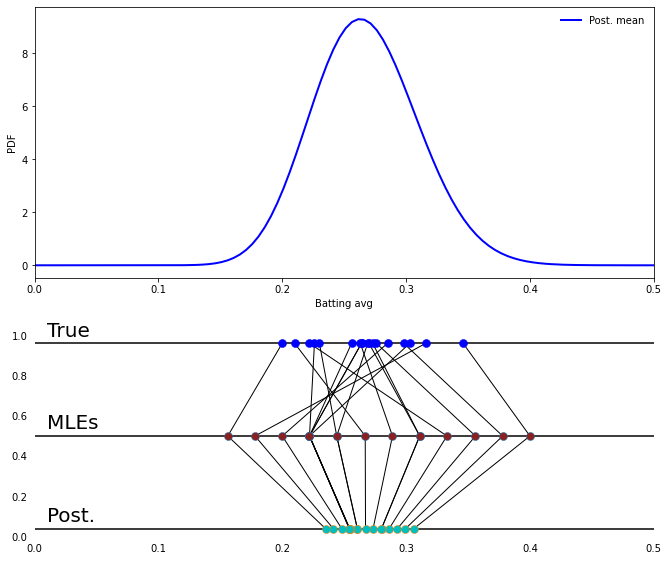

In [23]:
# Plot the best-fit pop'n dist'n and the point estimates,
# displaying shrinkage.

# Best-fit beta PDF:
avals = linspace(0., 1., 200)
# This uses the posterior mean (mu, sig):
a, b = moments2ab(bb_fit.mu.mean, bb_fit.sig.mean)
beta_mean = stats.beta(a, b)
pdf_vals = beta_mean.pdf(avals)

# Collect the posterior mean batting avgs:
mbavgs = []
for i in range(n_players):
    mbavgs.append(bb_fit.bavgs[i].mean)
mbavgs = array(mbavgs)

# args are (x,y) for PDF, then "true", MLEs, posterior pt estimates
ax_pdf, ax_pts = shrinkage_plot(avals, pdf_vals, bbdata['Remainder'], bbdata['First45'],
              mbavgs, xlabel='Batting avg', pdf_label='Post. mean')

ax_pdf.set_xlim(0., 0.5)
ax_pts.set_xlim(0., 0.5);

In [22]:
mle_errs = bbdata['First45'] - bbdata['Remainder']
shrink_errs = mbavgs - bbdata['Remainder']
print('RMS errors:\n  MLEs: {:.4f}\n  Post: {:.4f}'.format(sqrt(mean(mle_errs**2)),
                                                          sqrt(mean(shrink_errs))))

RMS errors:
  MLEs: 0.0647
  Post: 0.0421
